<h2> DATA 319: Model-based and Data-based Methods for Data Analytics. Summer 2024 </h2>
<h3> Problem Set 4 </h3>
<h3> Team <i> (Insert your team number here) </i></h3>
<h3> Type students' names <i> (only those who contributed to the group work)</i> here</h3>

*The purpose of this problem set is for you to explore implementations of recommendation system methods on real-world datasets. You will be evaluated on both your Python implementation, as well as your written responses to the discussion questions and theoretical derivations. This problem set is based on HW2 assignment of Stanford CS 246 course.*

#### 1. Latent Feature Model

The goal of this problem is to implement the Stochastic Gradient Descent algorithm to build a Latent Factor Recommendation system. We can use it to recommend movie to users. Suppose that we have a matrix $R$ of ratings where the element $R_{i,u}$ is the rating given to item $i$ by user $u$. The size of $R$ is $m\times n$, where $m$ is the number of movies and $n$ is the number of users. Note that most elements of the matrix are unknown/empty, since each user can only rate/view a small proportion of all of the movies. 

Our goal is to find two matrices $P$ and $Q$ so that $R\sim QP^T$ where $Q$ is $m\times k$ and $P$ is $n\times k$, where $k$ will be  parameter of our algorithm. The error metric we will use is: 

$$E = \left( \sum_{i\sim u} (R_{i,u}-q_ip_u^T)^2\right) + \lambda \left( \sum_{u} ||p_u||_2^2 + \sum_i ||q_i||_2^2 \right)$$

Where $i\sim j$ means that we only sum over entries where the user actually rated that item (That is, the entries in $R$ that are known), $q_i$ is the ith row of $Q$,corresponding to an item, and $p_u$ is the uth row of $P$, corresponding to a user, so rhese are both vectors of size $k$. The regularization parameter is $\lambda$ and $||\cdot ||_2^2$ is the sum of the squares of the vector entries.

If $\varepsilon_{i,u}$ denotes the derivative of $E$ with respect to $R_{i,u}$ then $$\varepsilon_{i,u} = 2(R_{i,u} - q_i\cdot p_u^T)$$ and the  update equations for $q_i$ and $p_u$ in stochastic gradient descent are: 
$$q_i = q_i + \eta (\varepsilon_{i,u}p_u -2\lambda q_i)$$
$$p_u = p_u + \eta(\varepsilon_{i,u}q_i - 2\lambda p_u)$$

Implement the algorithm using the updates described in the previous part. Read each entry of $R$ from disk and update $\varepsilon_{i,u}$, $q_i$, and $p_u$ for each entry. This means that you should not store $R$ in memory. Instead, you should  read each element sequentially and apply the update equations to each element at each iteration. Thus, each iteration will read the whole file.

Set $k=20$, $\lambda = \frac{1}{10}$, and the number of iterations to 40. Find a reasonable value for the learning rate, starting with $\eta=\frac1{10}$. The error on the training set should be below 70,000 after 40 iterations and $q_i$ and $p_i$ should have converged:
- if $\eta$ is too large, the error value can converge to something too large or may not monotonically decrease (it can fail to converge);
- if $\eta$ is too small, the error function doesn't have time to decrease within 40 steps.

Use the dataset ratings.train.txt included with the assignment, which is formatted as a matrix $R$ as described above. Plot the value of $E$ as a function of the number of iterations for your value of $\eta$.

*Hints*:
- You might try to initialize $P$ and $Q$ to random values in $[0,\sqrt{\frac5k}]$ so that $q_i\cdot p^T_u \in [0,5]$.
- In the update step $q_i$ and $p_u$ depend on each other. Compute the new values for each depending on all of the old values and then update both vectors at once.
- $E$ should be computed at the end of the full iteration, not elementwise while the matrices are being updated. 

Iteration 1 E: 83800.19465365986
Iteration 2 E: 81122.11844919293
Iteration 3 E: 80027.1292542575
Iteration 4 E: 78994.9093743945
Iteration 5 E: 77659.16531925558
Iteration 6 E: 75907.83096455285
Iteration 7 E: 73901.0738192659
Iteration 8 E: 71885.32737941275
Iteration 9 E: 69962.94939471352
Error is less than 70000 :)
Iteration 10 E: 68137.48315081694
Error is less than 70000 :)
Iteration 11 E: 66406.82863145294
Error is less than 70000 :)
Iteration 12 E: 64781.520535290445
Error is less than 70000 :)
Iteration 13 E: 63274.19317980335
Error is less than 70000 :)
Iteration 14 E: 61891.424954172
Error is less than 70000 :)
Iteration 15 E: 60632.37985450449
Error is less than 70000 :)
Iteration 16 E: 59490.90326367433
Error is less than 70000 :)
Iteration 17 E: 58458.084034283704
Error is less than 70000 :)
Iteration 18 E: 57524.098937921546
Error is less than 70000 :)
Iteration 19 E: 56679.25049608626
Error is less than 70000 :)
Iteration 20 E: 55914.449324178124
Error is less than 700

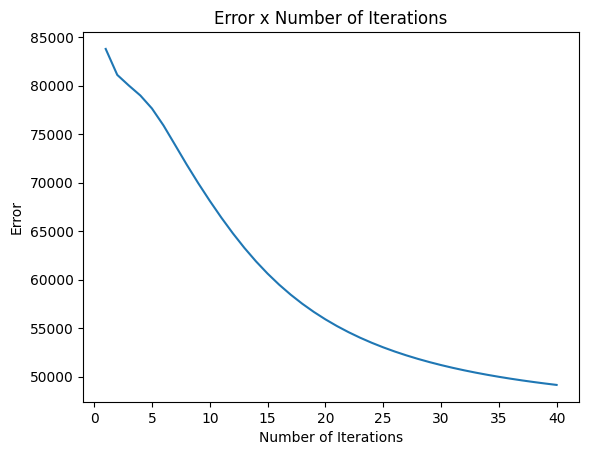

In [1]:
#Type your code for problem 1 below:
import numpy as np
import matplotlib.pyplot as plt

#Load Data
ratings_train_data = np.loadtxt('/Volumes/T7 Shield APFS/Data-319-Model-Data-Based-Methods/Problem Sets/Problem Set 4/ratings.train.txt')

#params
m = int(np.max(ratings_train_data[:, 0]))
n = int(np.max(ratings_train_data[:, 1]))
k = 20
lambd = 1/10
eta = 1/100
iterations = 40
Q = np.random.rand(m, k) * np.sqrt(5/k) #init p and q
P = np.random.rand(n, k) * np.sqrt(5/k)


def calc_e(R, Q, P, lambd):
    '''This function computes the error of the model given the R Q P and lambda values.'''
    error = 0
    for j in range(R.shape[0]):
        i, u, r = int(R[j, 0]) - 1, int(R[j, 1]) - 1, R[j, 2]
        error += (r - np.dot(Q[i], P[u])) ** 2
    error += lambd * (np.sum(np.linalg.norm(P, axis=1)**2) + np.sum(np.linalg.norm(Q, axis=1)**2))
    return error


#SGD
e = []
iteration = 1
while iteration <= iterations:
    for count in range(ratings_train_data.shape[0]):
        i, u, r = int(ratings_train_data[count, 0]) - 1, int(ratings_train_data[count, 1]) - 1, ratings_train_data[count, 2]
        error_iu = 2 * (r - np.dot(Q[i], P[u]))
        Q[i] += eta * (error_iu * P[u] - 2 * lambd * Q[i])
        P[u] += eta * (error_iu * Q[i] - 2 * lambd * P[u])
    e.append(calc_e(ratings_train_data, Q, P, lambd))
    print('Iteration', iteration, 'E:', e[-1])
    if e[-1] < 70000:
        print('Error is less than 70000 :)')
    iteration += 1


#Plot
plt.plot(range(1, iterations + 1), e)
plt.xlabel('Number of Iterations')
plt.ylabel('Error')
plt.title('Error x Number of Iterations')
plt.show()

#### 2. Collaborative Filtering Systems

Consider a user-item dataset where every datapoint consists of information matching user $U$ to an item $I$. Just as in the previous part, we can represent this with a matrix $R$ where each row corresponds to a user and each column corresponds to an item, so that $R_{i,j}=1$ means that user $i$ likes item $j$ and otherwise $R_{i,j}=0$. We'll  assume we have $m$ users and $n$ items, so that $R$ is $m\times n$. 

We'll now define an $m\times m$ matrix $P$ to be a diagonal matrix whose diagonal entries are the number of items liked by person $i$ and $Q$ an $n\times n$ diagonal matrix is the number of users that like item $i$. 

The non-normalized user similarity matrix is defined by $T=RR^T$. Explain the interpretation of $T_{i,i}$ and $T_{i,j}$ in terms of the underlying data. 

Define the item similarity matrix $S_I$ to be an $n\times n$ matrix so that the $i,j$ element is the cosine similarity of item $i$ and item $j$, which corresponds to the ith and jth columns of $R$. Observe that $$S_I=Q^{-1/2}R^TRQ^{-1/2}$$ where $Q^{-1/2}$ is $Q_{r,c}^{-1/2} = 1/\sqrt{Q_{r,c}}$ for all non-zero entries of $Q$ and 0 everywhere else. 

We can also define a user similarity matrix whose entries are the cosine similarities of the users (rows of $R$). Further note that we get an expression for $S_U$ in terms of $R$, $P$, and $Q$: $$P^{-1/2}RR^TP^{-1/2} $$

The recommendation method for user-user collaborative filtering for user $u$, can be described as follows: for all items $s$ compute $$r_{u,s} = \sum_{x\in \textrm{items}}\operatorname{cos-sim}(x,u)R_{x,s}$$ and recommend the $k$ items for which $r_{u,s}$ is the largest. Similarly, the item-item collaborative filter for user $u$ works by evaluating: 
    
$$r_{u,s} = \sum_{x\in\textrm{items}} R_{u,x}\operatorname{cos-sim}(x,s)$$ over all items $s$ and picking the $k$ items for which $r_{u,s}$ is the largest.

In practice, to do this we will define a recommendation matrix $\Gamma$, which is an $m\times n$ matrix where $\Gamma_{i,j} = r_{i,j}$. To find $\Gamma$ for both item-item and user-user collaborative filtering approaches, in terms of $R$, $P$, and $Q$, we can expand out the matrices in terms of $S_u$ and $S_I$ to get: 
$$\Gamma = P^{-1/2}RR^TP^{-1/2}R$$
and 
$$\Gamma = RQ^{-1/2}R^TRQ^{-1/2}.$$

Your task is to apply this method to the provided dataset about television shows, which has just under 1000 users and just over 500 shows, recording which users watched which shows over a three month period. The data is stored in user-shows.txt, which has the ratings matrix $R$, where each row corresponds to a user and each column corresponds to a TV show, with $R_{i,j}=1$ if user $i$ watched show $j$. The shows.txt file contains the names of the shows, in the same order as the columns of $R$. 

Compare the user-user  and item-item filtering method for the 500th user of the data (indexed 499 in Python). The first 100 entries of this row in the matrix have been deleted and replaced with zeros, so our goal is to estimate which of the shows this user might like: 
1. Compute the matrices $P$ and $Q$
2. Using the formulas above, compute $\Gamma$ for user-user collaborative filtering. Let $S$ denote the set of the first 100 shows. From $S$, which are the five that have the highest similarity scores to user 500? In the case of ties use the one with the lower index. Use the names from the provided file to answer this question. 
3. Compute $\Gamma$ for movie-movie collaborative filtering. From all the shows in $S$ which are the five with the highest similarity scores? In the case of ties use the one with the lower index. Use the names from the provided file to answer this question. 

*Hints*:
- The cosine similarity of two vectors $u$ and $v$ is $\dfrac{u\cdot v}{||u||||v||}$
- For the item-item case the matrix is $\Gamma = RQ^{-1/2}R^TRQ^{-1/2}$. 
- The highest similarity score for user-user should be over 900 and your highest similarity score for movie-movie should be over 31.

In [2]:
# Type your code for problem 2 below:  
